In [ ]:
# pip install Bio

starting count
	count vertices: 229757
	count edges: 564929
count after concatenation
	count vertices: 200018
	count edges: 535190
count after deleted tips
	count vertices: 199920
	count edges: 535092
count after deleted bubbles
	count vertices: 199920
	count edges: 535092


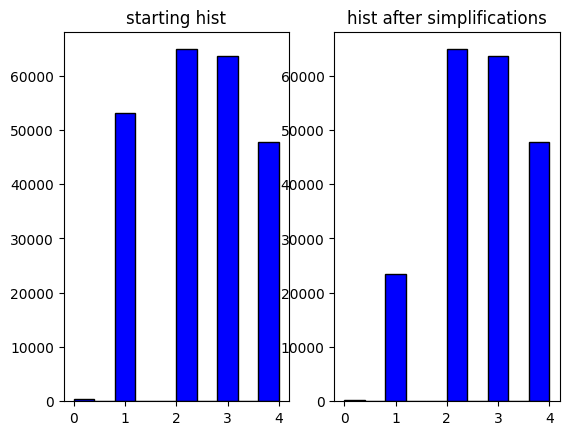


Reduced the number of vertices by 29837, the number of edges by 29837.


In [6]:
import sequence as sq
import random
import matplotlib.pyplot as plt
import subprocess


class Node:
    def __init__(self, val: str):
        self.val = val
        self.nxt = []  # list of tuple [ (Node, out_count, '') , (), ... ]
        self.count = 0  # in_count

    def __eq__(self, other) -> bool:
        return self.val == other.val

    def __hash__(self) -> int:
        return hash(self.val)

    def __repr__(self):
        return f'{self.val}'

    def nxt_vert(self, vert):
        vert.count += 1
        for i in range(len(self.nxt)):
            if self.nxt[i][0] == vert:
                count = self.nxt[i][1]
                self.nxt[i] = (vert, count + 1, vert.val[-1])
                break
        else:
            self.nxt.append((vert, 1, vert.val[-1]))


class SeqFromReads:
    def __init__(self, k: int, reads: list):
        self.k = k
        self.reads = reads
        self.vertex = {}
        self.start_graph_counter = []
        self.start_vertex_count, self.start_edge_count = 0, 0

    def statistic(self, task: str = None):
        count_edge = 0
        for v in self.vertex:
            count_nxt = len(v.nxt)
            count_edge += count_nxt
        if not task:
            print('starting count')
            self.start_vertex_count, self.start_edge_count = len(self.vertex), count_edge
            for v in self.vertex:
                self.start_graph_counter.append(len(v.nxt))
        else:
            print(f'count after {task}')
        print(f'\tcount vertices: {len(self.vertex)}')
        print(f'\tcount edges: {count_edge}')

    def k_mers(self):
        k = self.k - 1  # k-1 mers
        for rd in self.reads:
            for i in range(len(rd) - k):
                v_i = Node(rd[i:i + k])
                v_j = Node(rd[i + 1:i + k + 1])
                if v_i not in self.vertex:
                    self.vertex[v_i] = v_i
                if v_j not in self.vertex:
                    self.vertex[v_j] = v_j
                self.vertex[v_i].nxt_vert(self.vertex[v_j])

    def concatenate(self):
        self.k_mers()
        self.statistic()
        del_vert = set()
        for idx, v in enumerate(list(self.vertex.keys())):
            if v in del_vert:
                continue
            edge_str, w, all_w = [], 0, 0
            for v_i, ind in zip(v.nxt, range(len(v.nxt))):
                i = v_i[0]
                if i.count == 1 and len(i.nxt) == 1:
                    start = v
                    edge_str.append(i.nxt[0][-1])
                    del_vert.add(i)
                    j = i.nxt[0][0]
                    w += i.nxt[0][1] * len(i.nxt[0][2])
                    all_w += i.nxt[0][1]
                    while j.count == 1 and len(j.nxt) == 1:
                        edge_str.append(j.nxt[0][-1])
                        del_vert.add(j)
                        j = j.nxt[0][0]
                    self.vertex[start].nxt[ind] = (j, w / all_w, ''.join(edge_str))
                    w, all_w = 0, 0

        for del_i in set(del_vert):
            del self.vertex[del_i]
        self.statistic('concatenation')

    def del_tips(self, per: float = 0.3):
        tips = []  # [ (Node, weight, Node_parent, index_nxt), (...), ... ]
        for v in self.vertex:
            for v_i, i in zip(v.nxt, range(len(v.nxt))):
                if v_i[0].count == 1 and len(v_i[0].nxt) == 0:
                    tips.append((v_i[0], v.nxt[i][1] * len(v.nxt[i][2]), v, i))
        tips = sorted(tips, key=lambda x: x[1])

        for i in range(round(per * len(tips))):
            del self.vertex[tips[i][0]]
            del self.vertex[tips[i][2]].nxt[tips[i][3]]
        self.statistic('deleted tips')

    def del_bubbles(self, min_len: int = None):
        min_len = self.k if not min_len else min_len
        bubbles = []
        for v in self.vertex:
            count_nxt = len(v.nxt)
            if count_nxt < 2:
                continue
            for i in range(count_nxt):
                for j in range(i + 1, count_nxt):
                    v_i, v_j = v.nxt[i][0].nxt, v.nxt[j][0].nxt
                    if len(v_i) == 1 and len(v_j) == 1 and v_i[0][0] == v_j[0][0]:
                        len_up, len_down = len(v.nxt[i][2] + v_i[0][2]), len(v.nxt[j][2] + v_j[0][2])
                        if len_up > min_len and len_down > min_len:
                            continue
                        bubbles.append(v.nxt[i][0])
                        bubbles.append(v.nxt[j][0])
                        del self.vertex[v].nxt[i]

        for bubble in set(bubbles):
            del self.vertex[bubble]
        self.statistic('deleted bubbles')

    def print_graph(self):
        for i in self.vertex:
            print(f'v_i = {i}, input = {i.count}, output = {len(i.nxt)}')
            for j in i.nxt:
                print(f'{i} - {j[1]} - {j[2]} -> {j[0]} \t {j.count}')

    def disp_result(self):
        plt.subplot(1, 2, 1)
        plt.hist(self.start_graph_counter, color='blue', edgecolor='black')
        plt.title('starting hist')
        counter = []
        for v in self.vertex:
            counter.append(len(v.nxt))
        plt.subplot(1, 2, 2)
        plt.hist(counter, color='blue', edgecolor='black')
        plt.title(f'hist after simplifications')
        plt.show()

        count_edge = 0
        for v in self.vertex:
            count_nxt = len(v.nxt)
            count_edge += count_nxt
        print(f'\nReduced the number of vertices by {self.start_vertex_count - len(self.vertex)}, '
              f'the number of edges by {self.start_edge_count - count_edge}.')

    def full_analysis(self):
        self.concatenate()
        self.del_tips()
        self.del_bubbles()
        self.disp_result()


def data_for_test(file_name: str = None) -> list:
    if not file_name:
        sequence = sq.generate_randon_seq(10000)
        reads = sq.generate_reads(sequence, 100, random.randint(0, 9899))
        sq.create_fasta(reads, 'test')
    else:
        reads = sq.read_fasta(file_name)
    return reads


def data(file_input: str = 'input.fastq', file_output: str = 'trimmed.fastq') -> list:
    subprocess.run(
        f'java -jar trimmomatic-0.39.jar SE -phred33 {file_input} {file_output}'
        ' SLIDINGWINDOW:8:38 MINLEN:100'.split(' ')
    )
    return sq.read_fastq(file_output)


if __name__ == '__main__':
    # data = data(file_input='s_6_1.fastq')
    data = sq.read_fastq('trimmed')
    graph = SeqFromReads(10, data)
    graph.full_analysis()
